<a href="https://colab.research.google.com/github/Antony-M1/huggingface_eco/blob/main/fine_tune/Copy_of_Alpaca_%2B_Llama_3_8b_Unsloth_2x_faster_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth#installation-instructions---conda).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save) (eg for Llama.cpp).

**[NEW] Llama-3 8b is trained on a crazy 15 trillion tokens! Llama-2 was 2 trillion.**

Use our [Llama-3 8b Instruct](https://colab.research.google.com/drive/1XamvWYinY6FOSX9GLvnqSjjsNflxdhNc?usp=sharing) notebook for conversational style finetunes.

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers "trl<0.9.0" peft accelerate bitsandbytes

* We support Llama, Mistral, Phi-3, Gemma, Yi, DeepSeek, Qwen, TinyLlama, Vicuna, Open Hermes etc
* We support 16bit LoRA or 4bit QLoRA. Both 2x faster.
* `max_seq_length` can be set to anything, since we do automatic RoPE Scaling via [kaiokendev's](https://kaiokendev.github.io/til) method.
* With [PR 26037](https://github.com/huggingface/transformers/pull/26037), we support downloading 4bit models **4x faster**! [Our repo](https://huggingface.co/unsloth) has Llama, Mistral 4bit models.
* [**NEW**] We make Phi-3 Medium / Mini **2x faster**! See our [Phi-3 Medium notebook](https://colab.research.google.com/drive/1hhdhBa1j_hsymiW9m-WzxQtgqTH_NHqi?usp=sharing)

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",      # New Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",           # Llama-3 15 trillion tokens model 2x faster!
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",        # Phi-3 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",             # Gemma 2.2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.6
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.6 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [yahma](https://huggingface.co/datasets/yahma/alpaca-cleaned), which is a filtered version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html). You can replace this code section with your own data prep.

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

**[NOTE]** Remember to add the **EOS_TOKEN** to the tokenized output!! Otherwise you'll get infinite generations!

If you want to use the `llama-3` template for ShareGPT datasets, try our conversational [notebook](https://colab.research.google.com/drive/1XamvWYinY6FOSX9GLvnqSjjsNflxdhNc?usp=sharing).

For text completions like novel writing, try this [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing).

In [ ]:
import json
import pandas as pd
from huggingface_hub import login
from google.colab import userdata


In [ ]:
login(userdata.get('HUGGINGFACEHUB_API_TOKEN'))

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:

_info_docstatus = """In ERPNext, the `docstatus` column is an integer datatype column that serves to indicate the status of a document within the system. It can only hold one of three specific values: 0, 1, or 2. These values have distinct meanings that represent different stages in the lifecycle of a document:

                    - **0**: This value signifies that the document is in draft or save mode. In this state, the document is being worked on and may not yet be finalized or ready for submission or approval.

                    - **1**: When `docstatus` is set to 1, it indicates that the document has been submitted or approved. This status typically means that the document has completed any necessary review processes and is considered valid and ready for further processing or action.

                    - **2**: A `docstatus` value of 2 denotes that the document has been cancelled or rejected. This status indicates that the document is no longer valid or has been explicitly revoked, either due to a decision to cancel it before completion or because it was rejected after submission.

                    The `docstatus` column is crucial for workflow management within ERPNext, providing a clear and standardized way to track the progress and validity of documents. By restricting its values to 0, 1, or 2, ERPNext ensures consistency and clarity in document status management, facilitating efficient processing, auditing, and decision-making throughout the document lifecycle."""

_info_comment = """In ERPNext, the `_comments` column is a text datatype that stores a JSON-formatted list of comment objects. Each object in this list represents a comment made on the document, containing details such as the comment content, the email address of the user who made the comment, and a unique identifier for the comment. For example, the data might look like this:

```json
[
  {"comment": "<div class=\"ql-editor read-mode\"><p>Recent Comment</p></div>", "by": "devsupport@example.com", "name": "8224c49a17"},
  {"comment": "<div class=\"ql-editor read-mode\"><p>Test</p></div>", "by": "devsupport@example.com", "name": "2a9bf906ff"},
  {"comment": "<div class=\"ql-editor read-mode\"><p>Test 2</p><p><br></p></div>", "by": "devsupport@example.com", "name": "8d3fe9554e"},
  {"comment": "<div class=\"ql-editor read-mode\"><p>Test 3</p></div>", "by": "devsupport@example.com", "name": "c9e2771b8d"}
]
```

This structure captures all conversations related to the document, providing a historical record of discussions, feedback, and notes. Each comment is encapsulated within a `div` tag formatted for display in a rich text editor, ensuring that the content maintains its intended format and readability. The `by` field indicates the user who posted the comment, and the `name` field uniquely identifies each comment, allowing for precise tracking and management of discussions. This feature is essential for maintaining clear and organized communication within ERPNext, enabling users to collaborate effectively and keep track of all interactions related to a specific document."""

COMMON_FIELD_DESCRIPTIONS = {
    "name": """In ERPNext, the `name` column serves as the default primary key in all tables, ensuring that each record can be uniquely identified within the database. As a primary key, it is a critical component of the database schema, automatically guaranteeing uniqueness and preventing null values, which are essential for maintaining data integrity. The `name` field is often auto-generated by the system, particularly for standard documents such as invoices, purchase orders, and other transactional records, using predefined naming series to create unique identifiers. However, it can also be customized by users for specific requirements, allowing flexibility in naming conventions. This dual functionality of auto-generation and customization makes the `name` column a versatile and indispensable element in ERPNext's data management and record-keeping processes.""",
    "creation": "In ERPNext, the `creation` column is a `datetime` field that captures the precise date and time when a document or record is initially created in the database. This field is automatically populated by the system upon the creation of the record and remains immutable thereafter, ensuring a reliable timestamp that reflects the original creation moment. Unlike other fields that might be subject to updates during the lifecycle of a document, the `creation` field does not change once set. This immutable characteristic makes it a crucial element for tracking the historical creation data of records, facilitating audit trails, and maintaining data integrity within the ERPNext framework.",
    "modified": "In ERPNext, the `modified` column is a datetime field that stores the timestamp indicating the most recent update made to a document or record. This field is automatically updated every time any modification is applied to the corresponding form or record within the ERPNext system. Whether it's a change in data, addition of new information, or any other update action, the `modified` field reflects the exact date and time of the latest alteration. This feature allows users to easily track and retrieve recently updated documents by sorting or querying based on the `modified` timestamp. The format used for the datetime values in ERPNext is `%Y-%m-%d %H:%M:%S.%f`, where an example format would be `2022-04-27 15:52:20.377414`. This precise recording of modification timestamps serves critical purposes such as audit trails, version control, and ensuring accurate and up-to-date data across the ERPNext platform.",
    "modified_by": "In ERPNext, the `modified_by` column is a `varchar` datatype that serves as a FOREIGN KEY linked to the `tabUser` table. Its purpose is to track and record the user who last modified or updated a particular row or form within the ERPNext system. Whenever a user makes changes to any data associated with a record, whether it involves updating a single column or the entire row, the `modified_by` field is automatically updated with the username or identifier of the user who performed the modification. This functionality is crucial for maintaining accountability and traceability within the system, as it provides transparency regarding who made changes to the data and when. By linking to the `tabUser` table, ERPNext ensures that the `modified_by` column accurately reflects the identity of the user responsible for the most recent update, thereby supporting audit trails, compliance requirements, and collaborative data management practices across the platform.",
    "owner": "In ERPNext, the `owner` column is a `varchar` datatype that serves as a FOREIGN KEY linked to the `tabUser` table. Its primary function is to identify and record the user who initially created a specific document or record within the ERPNext system. Upon the creation of a new document, the `owner` field is set to indicate the user responsible for its creation. Unlike the `modified_by` field, which tracks the latest user to modify the document, the `owner` field remains unchanged after its initial assignment during creation. This static assignment of ownership provides a clear and permanent record of the document's creator, facilitating accountability and ownership attribution throughout the document's lifecycle. By linking directly to the `tabUser` table, ERPNext ensures that the `owner` column accurately reflects the user identity associated with the creation of each document, supporting governance, compliance, and administrative functions within the ERPNext environment.",
    "docstatus": _info_docstatus,
    "parenttype": """In ERPNext, the `parenttype` column is a `varchar` datatype primarily used in child tables to establish a relationship with the parent document type. This column links to the `tabDocType` table, which defines the various document types or models within the ERPNext database. The `parenttype` field specifies which parent document type (doctype) the current child table row is associated with. Essentially, it indicates the type of document to which the child record belongs. For example, if a child table contains line items for invoices, the `parenttype` might be set to "Sales Invoice" to show that these line items belong to sales invoices. This linkage is crucial for maintaining the relational integrity and hierarchical structure of data within ERPNext, ensuring that child records are properly associated with their respective parent documents. By utilizing the `parenttype` column, ERPNext efficiently organizes and manages complex data relationships, allowing for more streamlined data handling, querying, and reporting across the system.""",
    "parent": """In ERPNext, the `parent` column is a `varchar` datatype commonly used in child tables to create a link with a specific record in a parent document type. The exact parent document is determined by the value specified in the `parenttype` column. For instance, if the `parenttype` is set to "Sales Invoice," the `parent` column will contain a unique identifier, such as `SI-0001`, representing a specific Sales Invoice document. This means that the current row in the child table is associated with and belongs to the Sales Invoice identified by `SI-0001`. The `parent` column thus plays a crucial role in maintaining the hierarchical structure of data within ERPNext, ensuring that each child record is properly linked to its corresponding parent document. This relationship facilitates accurate data management, retrieval, and reporting, allowing ERPNext to effectively handle complex data dependencies and maintain relational integrity across different document types.""",
    "parentfield": """In ERPNext, the `parentfield` column is a `varchar` datatype that is predominantly used in child tables to specify the particular field in the parent document where the child records are stored. This column is essential when a single parent document can contain multiple child tables, each represented in different fields within the same document. The `parentfield` value indicates which field in the parent document the child table row belongs to, allowing for the correct association of child records with their respective sections within the parent document. For example, if a "Sales Invoice" document has separate fields for "items" and "taxes," the `parentfield` column would differentiate between these fields, ensuring that each child record is accurately linked to either the "items" or "taxes" section. This functionality is crucial for managing complex documents where multiple child tables are present, as it maintains the integrity and organization of data by clearly defining the context and location of each child record within the parent document.""",
    "idx": """In ERPNext, the `idx` column is an integer datatype used in child tables to specify the order of the rows within the table. This column determines the sequence in which child records appear, providing a way to control the visual presentation of data to the user. By assigning an index value to each row, ERPNext ensures that records are displayed in a consistent and meaningful order, which enhances data readability and user experience. The `idx` column is particularly useful in scenarios where the order of items matters, such as line items in an invoice or steps in a workflow. This ordering is purely for data visualization purposes and does not impact the underlying data relationships or integrity. By managing the display order through the `idx` column, ERPNext allows users to intuitively navigate and interpret complex data structures.""",
    "_assign": """In ERPNext, the `_assign` column is a text datatype that stores a list of user email addresses in JSON format, such as `["abbas.jakeer@example.com", "abdul.a@example.com", "abdul.kareem@example.org", "abdul.noordeen@example.org"]`. Each email address corresponds to the `name` column in the `tabUser` table, serving as the primary key for identifying users within the system. This column is used to track which users are assigned to a particular document, facilitating task delegation and responsibility management. When a document has users listed in the `_assign` column, ERPNext automatically creates corresponding tasks in the `tabToDo` table for each assigned user. This functionality ensures that all listed users are notified and can track their assigned tasks, promoting collaboration and efficient workflow management within the organization.""",
    "_comments": _info_comment,
    "_liked_by":"""In ERPNext, the `_liked_by` column is a text datatype that stores a list of user email addresses in JSON format, such as `["abbas.jakeer@softsuave.com", "abdul.a@softsuave.com", "abdul.kareem@softsuave.org", "abdul.noordeen@softsuave.org"]`. Each email address corresponds to the `name` column in the `tabUser` table, which acts as the primary key for identifying users. This column is used to track which users have liked a particular document, essentially serving as a way to mark users' approval or endorsement of the document. By examining the `_liked_by` column, it is possible to determine all the users who have expressed their preference for or engagement with the document. This feature supports social interaction and feedback within the ERPNext platform, enhancing user engagement and providing insights into the document's popularity or approval among users.""",
    "_user_tags": """In ERPNext, the `_user_tags` column is a text datatype that stores a comma-separated list of tags, formatted like `,tag1,tag2,tag3`. These tags are user-defined keywords or phrases associated with a document, enabling efficient categorization and retrieval of documents based on specific text tags. By tagging documents with relevant keywords, users can enhance the searchability and organization of records within the system. When searching for documents, users can utilize these tags to quickly filter and find documents that match specific criteria or topics. The `_user_tags` column facilitates a more intuitive and effective search experience, helping users to manage and navigate large volumes of data with ease. This tagging system promotes better data organization, quick access to relevant information, and improved workflow efficiency in ERPNext."""

}

In [ ]:
def get_table_in_json_format(table_dict:str) -> str:

    table_dict = eval(table_dict)
    table_df = pd.DataFrame(table_dict)

    table_df.columns = table_df.columns.str.lower()

    table_name = table_df["table_name"][0]

    columns = []

    for index, row in table_df.iterrows():
        row = row.fillna(False)
        temp = {
            "name": row.column_name,
            "data_type": row.data_type,
            "ordinal_position": row.ordinal_position
        }

        if row.character_maximum_length:
            temp["character_maximum_length"] = row.character_maximum_length
        if row.constraint_type:
            temp["constraint_type"] = row.constraint_type
        if row.referenced_table_schema:
            temp["referenced_table_schema"] = "erpnext_sample_db"
        if row.referenced_table_name:
            temp["referenced_table_name"] = row.referenced_table_name
        if row.referenced_column_name:
            temp["referenced_column_name"] = row.referenced_column_name
        # if COMMON_FIELD_DESCRIPTIONS.get(row.column_name):
        #     temp["description"] = COMMON_FIELD_DESCRIPTIONS[row.column_name]

        columns.append(temp)

    table_json_string = json.dumps({
        "table": table_name,
        "columns": columns
    })

    return json.loads(table_json_string)

In [ ]:
DATA_PASSED_TO_LLM = []

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    # instructions = examples["instruction"]
    inputs       = examples["query"]
    outputs      = examples["sql"]
    table_dict_str = [table.replace('nan', 'None') for table in examples["table_dict"]]
    sql_scripts = examples["sql_script"]
    texts = []
    for input, output, table_dict, sql_script in zip(inputs, outputs, table_dict_str, sql_scripts):
        table_json_str = get_table_in_json_format(table_dict)
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        instruction = f"""
    Using the provided table schema information in JSON format, generate an optimized SQL query for ERPNext.
    Please ensure the query adheres to the following guidelines:
    1. Clearly define the SELECT clause to include only the necessary columns.
    2. Use appropriate JOINs to combine data from multiple tables based on relationships.
    3. Apply WHERE clauses to filter data accurately according to the given requirements.
    4. Include ORDER BY clauses to sort the results if needed.
    5. Use GROUP BY clauses for aggregation if applicable.
    6. Ensure the query is efficient and performs well with large datasets.

    Here the Question: {input}
  """

        llm_input = f"""Here is the ERPNext Table Schema Information in JSON format: {table_json_str}"""
        DATA_PASSED_TO_LLM.append({
            "input": llm_input,
            "output": output,
            "instruction": instruction
        })
        text = alpaca_prompt.format(instruction, llm_input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("antony-pk/erpnext-sql-query-schema-v1-ds", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/15761 [00:00<?, ? examples/s]

In [ ]:
DATA_PASSED_TO_LLM_df = pd.DataFrame(DATA_PASSED_TO_LLM)
DATA_PASSED_TO_LLM_df.to_csv("./dataset_passed_to_llm.csv")

In [ ]:
print(dataset['text'][1000])

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:

    Using the provided table schema information in JSON format, generate an optimized SQL query for ERPNext.
    Please ensure the query adheres to the following guidelines:
    1. Clearly define the SELECT clause to include only the necessary columns.
    2. Use appropriate JOINs to combine data from multiple tables based on relationships.
    3. Apply WHERE clauses to filter data accurately according to the given requirements.
    4. Include ORDER BY clauses to sort the results if needed.
    5. Use GROUP BY clauses for aggregation if applicable.
    6. Ensure the query is efficient and performs well with large datasets.

    Here the Question: Group by net_weight_uom in the Packing Slip table and list the count of each group.
  

### Input:
Here is the ERPNext Table Schema Information in JSON format: {'table'

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

hello world


In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 6,
        warmup_steps = 5,
        num_train_epochs = 1,
        # max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        resume_from_checkpoint = "/content/outputs/checkpoint-500"
    ),
)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/15761 [00:00<?, ? examples/s]

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
5.594 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 15,761 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 6
\        /    Total batch size = 24 | Total steps = 656
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,0.795000
2,0.752700
3,0.723700
4,0.679100
5,0.536400
6,0.499300
7,0.430700
8,0.413000
9,0.310500
10,0.279500


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

2709.5243 seconds used for training.
45.16 minutes used for training.
Peak reserved memory = 10.113 GB.
Peak reserved memory for training = 4.519 GB.
Peak reserved memory % of max memory = 68.572 %.
Peak reserved memory for training % of max memory = 30.641 %.


# Graph

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
# Extract the log history
log_history = trainer.state.log_history

## Plot Training Loss

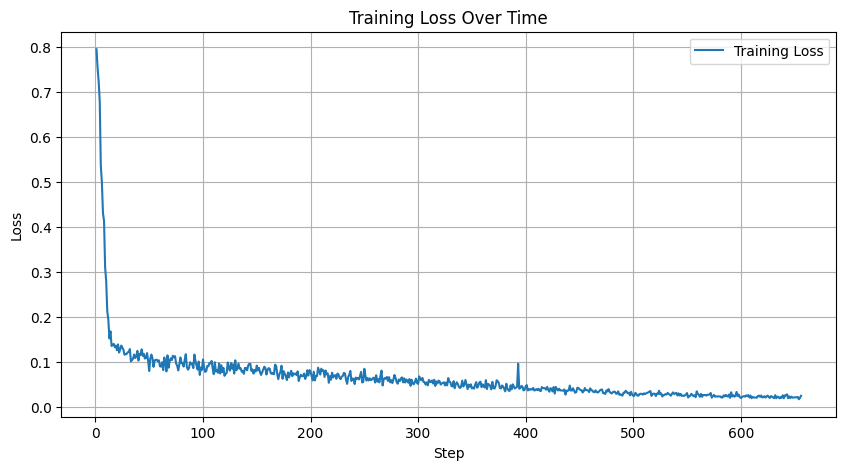

In [ ]:
# Extract the steps and losses
steps = [entry["step"] for entry in log_history if "loss" in entry]
losses = [entry["loss"] for entry in log_history if "loss" in entry]

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

## Plot Learning Rate

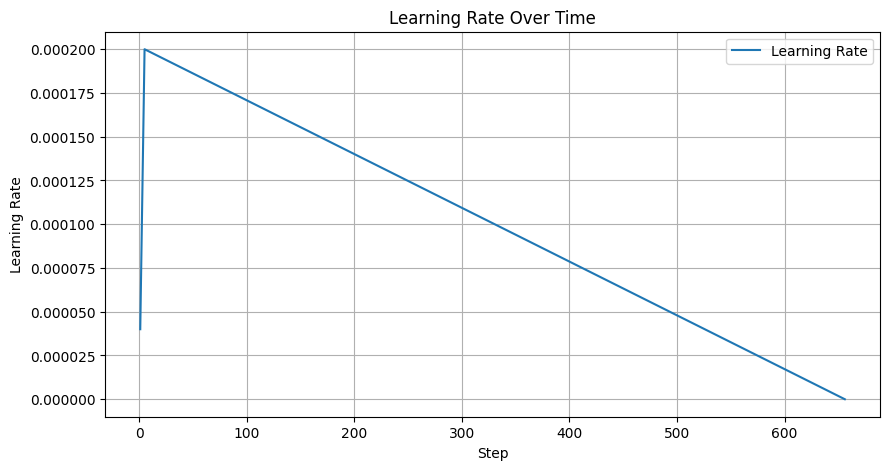

In [ ]:
# Extract the learning rates
learning_rates = [entry["learning_rate"] for entry in log_history if "learning_rate" in entry]

# Plot the learning rate
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Over Time")
plt.legend()
plt.grid(True)
plt.show()


## Save Logs in Json Format

In [ ]:
with open("training_log.json", "w") as f:
    json.dump(log_history, f)

<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Generate The SQL query for ERPNext", # instruction
        "How many employee there?", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate The SQL query for ERPNext\n\n### Input:\nHow many employee there?\n\n### Response:\nSELECT COUNT(*) FROM `tabEmployee`;<|end_of_text|>']

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Continue the fibonnaci sequence.

### Input:
1, 1, 2, 3, 5, 8

### Response:
13<|end_of_text|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
repo_name = "antony-pk/unsloth-llama-3-8b-bnb-4bit-schema-json-j27"

In [ ]:
# Push To hub
model.push_to_hub(repo_name, private=True) # Online saving
tokenizer.push_to_hub(repo_name, private = True) # Online saving

README.md:   0%|          | 0.00/576 [00:00<?, ?B/s]

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# alpaca_prompt = You MUST copy from above!

inputs = tokenizer(
[
    alpaca_prompt.format(
        "What is a famous tall tower in Paris?", # instruction
        "", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


["<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is a famous tall tower in Paris?\n\n### Input:\n\n\n### Response:\nThe Eiffel Tower is a famous landmark in Paris, France. It is a wrought iron tower that was built in 1889 for the World's Fair. Standing at 324 meters tall, it is the tallest building in Paris and one of the most recognizable landmarks in the world.<|end_of_text|>"]

You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Mistral 7b [free Kaggle version](https://www.kaggle.com/code/danielhanchen/kaggle-mistral-7b-unsloth-notebook)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!
7. `ChatML` for ShareGPT datasets, [conversational notebook](https://colab.research.google.com/drive/1Aau3lgPzeZKQ-98h69CCu1UJcvIBLmy2?usp=sharing)
8. Text completions like novel writing [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing)
9. [**NEW**] We make Phi-3 Medium / Mini **2x faster**! See our [Phi-3 Medium notebook](https://colab.research.google.com/drive/1hhdhBa1j_hsymiW9m-WzxQtgqTH_NHqi?usp=sharing)

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Support our work if you can! Thanks!
</div>